In [107]:
import numpy as np
import h5py
import seaborn
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
import multiprocessing as mp
import glob
import sys
from functools import partial
from sklearn.cluster import DBSCAN
import matplotlib as mpl
import collections

In [56]:
def KSVM_dataprep(image,threshold=99):
    # this function processed the image data into a few selected pixels whose absolute Bz magnitude
    # is among the threshold-percentile of all pixels with the same polarity label
    height = image.shape[0]
    width = image.shape[1]
    image = np.nan_to_num(image)

    new_data = []
    data_weight = []
    data_label = []
    pos_weight = []
    neg_weight = []
    valid_image = 1 # return a valid image flag with value=1 meaning that both pos/neg polars exist

    for i in range(height):
        for j in range(width):
            # Firstly, make the polarity of each pixel right

            pixel = image[i,j]

            if pixel>0:
                data_label.append(1)
                pos_weight.append(np.abs(pixel))
            else:
                data_label.append(-1)
                neg_weight.append(np.abs(pixel))

            # secondly, make the weights right
            data_weight.append(np.abs(pixel))

            # Finally, append the coordinates
            new_data.append(np.array([i,j]))

    if len(pos_weight)>0 and len(neg_weight)>0:
        pos_weight, neg_weight = np.array(pos_weight), np.array(neg_weight)
        pos_threshold = np.percentile(pos_weight, q=threshold)
        neg_threshold = np.percentile(neg_weight, q=threshold)
    else:
        valid_image = 0

    if valid_image==1:
        final_data = list(zip(new_data,data_weight,data_label))
        selected_data = []

        for item in final_data:
            if item[2]==1:
                if item[1]>=pos_threshold:
                    selected_data.append(item)
            if item[2]==-1:
                if item[1]>=neg_threshold:
                    selected_data.append(item)

        new_data, data_weight, data_label = zip(*selected_data)
        return np.array(new_data), np.array(data_weight), np.array(data_label), valid_image
    else:
        return [], [], [], valid_image

def KSVM_fit(pixel_coor, pixel_weight, pixel_polarity,valid_image,penalty_C=1.0):
    #pixel_coor, pixel_weight, pixel_polarity = KSVM_dataprep(image)
    if valid_image==1:
        classifier = SVC(C=penalty_C,kernel='rbf',probability=True,gamma='auto',random_state=40)
        classifier.fit(pixel_coor,pixel_polarity,sample_weight=pixel_weight)

        return classifier
    else:
        return valid_image

def KSVM_final(image,penalty_C=1.0,threshold=99,show=False,imagename='Nil'):
    # this function is the final version of Kernel SVM model, and the parameters are:
    # image: the image input
    # penalty_C: the margin parameter (the larger it is, the smaller margin the SVM model would use)
    # threshold: the percentile at which pixels are selected for doing the SVM

    # output: the PIL pixels for the image
    # print(imagename)
    height = image.shape[0]
    width = image.shape[1]
    
    pixel_coor, pixel_weight, pixel_polarity, valid_image = KSVM_dataprep(image, threshold=threshold)
    model = KSVM_fit(pixel_coor, pixel_weight, pixel_polarity, valid_image, penalty_C=penalty_C)

    if valid_image==0:
        return (imagename,np.array([]))
    else:
        # firstly, we should select a binding box in which we draw the PIL
        row_top = np.min(pixel_coor[:,0])
        row_bottom = np.max(pixel_coor[:,0])
        column_top = np.min(pixel_coor[:,1])
        column_bottom = np.max(pixel_coor[:,1])

        # secondly, we draw a subgrid inside
        x = np.linspace(row_top, row_bottom, num=len(list(range(row_top,row_bottom+1))))
        y = np.linspace(column_top, column_bottom, num=len(list(range(column_top,column_bottom+1))))

        xv, yv = np.meshgrid(x,y,indexing='xy')
        xv,yv = np.ndarray.flatten(xv), np.ndarray.flatten(yv)
        thegrid = np.array([xv,yv]).transpose()

        proba = model.predict_proba(thegrid)[:,0]
        boundary_point = [(int(thegrid[i,0]), int(thegrid[i,1])) for i in range(len(proba)) if proba[i]>=0.47 and proba[i]<=0.53]
        boundary_point = list(set(boundary_point))
        boundary_point = np.array(boundary_point)
        

        if show==True:
            fig = plt.subplots(nrows=1, ncols=2)

            plt.subplot(1, 2, 1)
            seaborn.heatmap(image, center=0, cbar=False)

            plt.subplot(1, 2, 2)
            # plt.contourf(x,y,Z,cmap=plt.cm.coolwarm)
            plt.scatter(boundary_point[:, 1], boundary_point[:, 0], color='red', marker='o', s=1)
            plt.xlim(0, image.shape[1])
            plt.ylim(0, image.shape[0])
            plt.gca().invert_yaxis()
            plt.tick_params(labelbottom='off')
            plt.tick_params(labelleft='off')

            plt.show()
        else:
            return (imagename,boundary_point)

def PIL(file,threshold=99,penalty_C=1.0):
    thefile = h5py.File(file,'r')
    video = thefile['video0']
    framelist = list(video.keys())
    frames = sorted(framelist, key=lambda x: int(x[5:]), reverse=False)
    images = [video[f]['channels'][:,:,2] for f in frames]
    process_input = []

    for i in range(len(frames)):
        process_input.append((images[i],penalty_C,threshold,False,frames[i]))

    pool = mp.Pool(processes=8)
    #funcs = partial(KSVM_final,penalty_C=1.0,threshold=90,show=False)
    results = [pool.apply_async(KSVM_final,t) for t in process_input]
    output = [p.get() for p in results]

    filename = './final_result/'+file[3:-5]+'_PIL'+'.hdf5'
    PILfile = h5py.File(filename,mode='w')
    PILfile.create_group(name='video0')
    newvideo = PILfile['video0']

    for i in range(len(output)):
        framename = output[i][0]
        newvideo.create_group(name=framename)
        newframe = newvideo[framename]
        newframe.create_dataset(name='PIL',data=output[i][1])

    PILfile.close()

In [110]:
def clean_data(pixel_coor,pixel_weight,pixel_polarity,valid_image,eps=8,min_samples=5):
    if valid_image==1:
        whole_data = list(zip(pixel_coor,pixel_weight,pixel_polarity))
        pos_image = []
        neg_image = []
        
        for item in whole_data:
            if item[2]==1:
                pos_image.append(item)
            else:
                neg_image.append(item)
        
        pos_coor,pos_weight,pos_label = zip(*pos_image)
        neg_coor,neg_weight,neg_label = zip(*neg_image)
        pos_coor, neg_coor = np.array(pos_coor), np.array(neg_coor)
        
        clust = DBSCAN(eps=eps,min_samples=min_samples)
        pos_cluster = clust.fit_predict(X=pos_coor)
        neg_cluster = clust.fit_predict(X=neg_coor)
        
        return pos_coor, pos_cluster, neg_coor, neg_cluster
        
    else:
        return pixel_coor,pixel_weight,pixel_polarity,valid_image

In [111]:
pos_coor, pos_cluster, neg_coor, neg_cluster = clean_data(pixel_coor,pixel_weight,pixel_polarity,valid_image)

In [118]:
set(neg_cluster)

{-1,
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21}

In [116]:
the_coor = neg_coor
thecluster = neg_cluster

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


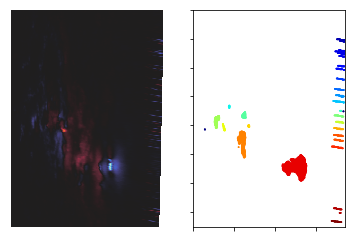

In [117]:
N = len(set(thecluster))
# define the colormap
cmap = plt.cm.jet
# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(cmap.N)]
# create the new map
cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)

# define the bins and normalize
bounds = np.linspace(-1,N,N+2)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
            
fig = plt.subplots(nrows=1, ncols=2)

plt.subplot(1, 2, 1)
seaborn.heatmap(image, center=0, cbar=False,xticklabels=False, yticklabels=False)
            
plt.subplot(1, 2, 2)
plt.scatter(the_coor[:, 1], the_coor[:, 0], c=thecluster,cmap=cmap, marker='o', s=0.5)
plt.xlim(0, image.shape[1])
plt.ylim(0, image.shape[0])
plt.gca().invert_yaxis()
plt.tick_params(labelbottom='off')
plt.tick_params(labelleft='off')

plt.show()

In [74]:
data = np.load('HARP377.npy')
image = data[1110,:,:]
%matplotlib inline

In [75]:
(imagename,boundary_point) = KSVM_final(image,threshold=97,show=False)

In [76]:
pixel_coor, pixel_weight, pixel_polarity, valid_image = KSVM_dataprep(image, threshold=97)
model = KSVM_fit(pixel_coor, pixel_weight, pixel_polarity, valid_image, penalty_C=1.0)

In [77]:
clust = DBSCAN(eps=30,min_samples=5)
thecluster = clust.fit_predict(X=boundary_point)

In [6]:
clusters = collections.defaultdict(list)
for point,c in list(zip(boundary_point,thecluster)):
    clusters[c].append(point)

In [60]:
clust_point = clusters[1]

In [61]:
line = PIL_line_drawing(clust_point)

In [97]:
def PIL_cluster(boundary_point,eps=30,min_samples=5):
    # this function aims at finding separate clusters of boundary points
    # inside each cluster, points are considered to be mutually reachable so that they are considered
    # to be on the same PIL line
    
    # params:
    # boundary_point: a 2-D numpy array of the selected boundary points which are the PIL candidates
        
    clust = DBSCAN(eps=eps,min_samples=min_samples)
    thecluster = clust.fit_predict(X=boundary_point)
    
    return thecluster

def closest_node(node, nodes):
    if type(nodes)!='numpy.ndarray':
        nodes = np.asarray(nodes)
    deltas = nodes - node
    dist_2 = np.einsum('ij,ij->i', deltas, deltas)
    return np.argmin(dist_2)

def closest_node_pair(point1,point2,nodes):
    pos_nodes = []
    neg_nodes = []
    x1, y1 = point1[0],point1[1]
    x2, y2 = point2[0],point2[1]
    midpoint = np.array([(x1+x2)/2,(y1+y2)/2])
    
    
    if x1!=x2: # the case where slope parameter is well-defined
        k = (y2-y1)/(x2-x1)
        b = y1-k*x1
        pos_nodes = [p for p in nodes if (k*p[0]-p[1]+b)>0] # points on the two sides
        neg_nodes = [p for p in nodes if (k*p[0]-p[1]+b)<0] # points on the two sides
    else:
        pos_nodes = [p for p in nodes if p[0]>x1]
        neg_nodes = [p for p in nodes if p[0]<x1]
        
    if len(pos_nodes)==0:
        pos_nodes = [point1]
    if len(neg_nodes)==0:
        neg_nodes = [point2]
    
    pos_nodes, neg_nodes = np.array(pos_nodes), np.array(neg_nodes)
    pos_point = closest_node(midpoint, pos_nodes)
    neg_point = closest_node(midpoint,neg_nodes)
    
    return pos_nodes[pos_point],neg_nodes[neg_point]

In [55]:
def PIL_line_drawing(clust_point):
    # this function aims at drawing the PIL line for each of the clust_point
    # input: an array of points in the same PIL component, shape = (num_points,num_dim)
    # output: the ordered list of points which designates the order of line drawing
    
    # firstly, we calculate the coordinate of the centroid
    centroid = np.mean(clust_point,axis=0).reshape((1,2)) # now we have the coordinate of the centroid
    clust_list = [p for p in clust_point]
    
    # next, we find the starting point of the PIL, which is supposed to be the point that is the most
    # distant from the centroid of the cluster
    
    distance = list(map(lambda x: np.linalg.norm(x-centroid),clust_point))
    index = distance.index(max(distance)) # this is the index for the starting point
    
    theline = [clust_point[index]]
    node = clust_point[index]
    clust_list = [ x for x in clust_list if not (x==node).all()]
    L = len(clust_list)
    
    for _ in range(L):
        nearest_point = closest_node(node,clust_list)
        node = clust_list[nearest_point]
        theline.append(node)
        clust_list = [ x for x in clust_list if not (x==node).all()]
    
    return theline

In [58]:
def clust_integration(model,pixel_coor,pixel_weight,pixel_label,line_point):
    # this function aims at calculating the gradient integration over a PIL
    # params:
    # pixel_*: see Gradient_Integration documentation
    # model: the trained SVM model
    # line_point: ordered point of the PIL, based on the result from function PIL_line_drawing
    
    integration = 0
    support_vectors = model.support_vectors_ # the support vectors
    valid_count = 0
    
    for k in range(len(line_point)-1):
        # the line to be considered now is the line connected by the two adjacent points on the line
        # namely line_point[k] and line_point[k+1]
        
        point1 = line_point[k]
        point2 = line_point[k+1]
        
        pos_node,neg_node = closest_node_pair(point1,point2,support_vectors)
        if (pos_node==point1).all():
            pos_weight = 0
        else:
            pos_index = [k for k in range(pixel_coor.shape[0]) if (pixel_coor[k]==pos_node).all()][0]
            pos_weight = pixel_weight[pos_index]*pixel_label[pos_index]

        
        if (neg_node==point2).all():
            neg_weight = 0
        else:
            neg_index = [k for k in range(pixel_coor.shape[0]) if (pixel_coor[k]==neg_node).all()][0]
            neg_weight = pixel_weight[neg_index]*pixel_label[neg_index]
        
        if pos_weight!=0 and neg_weight!=0:
            contrast = abs(pos_weight-neg_weight)
            integration += abs(contrast)
    
    return integration/(valid_count+1)

In [88]:
def Gradient_Integration(model,pixel_coor,pixel_weight,pixel_label,boundary_point,thecluster):
    # this function aims at calculating a numerical approximation for the integration of 
    # the gradients of the magnetic field along each PIL component identified from the DBSCAN clustering
    # and then only retain those PIL components that have the highest integration of gradients
    # and delete the rest
    
    # params:
    # pixel_coor: points selected for doing the kernel SVM classification
    # pixel_weight: the corresponding point's vertical magnetic component
    # pixel_label: the polarity of the selected points
    # boundary_point: a subset of pixel_coor, which are the points consisting the PIL candidates
    # thecluster: the PIL component label, different label means that points belong to different PIL line
    
    if min(thecluster)==-1: # there are some noisy points in the PILs identified
        newdata = []
        data = list(zip(boundary_point,thecluster))
        for item in data:
            if item[1]!=-1:
                newdata.append(item)
        boundary_point, thecluster = zip(*newdata)
    
        
    if len(set(thecluster))==1:
        return np.array(list(boundary_point))
    else:
        # create a list storing the integration for each of the cluster
        integration = [0]*len(set(thecluster))
        clusters = collections.defaultdict(list)
        for point,c in list(zip(boundary_point,thecluster)):
            clusters[c].append(point) # put points of different clusters into separate lists
        for k in clusters:
            clust_point = clusters[k]
            line = PIL_line_drawing(clust_point)
            integration[int(k)] = clust_integration(model,pixel_coor,pixel_weight,pixel_polarity,line)
            
        best_clust = integration.index(max(integration))
        newdata = []
        data = list(zip(boundary_point,thecluster))
        for item in data:
            if item[1]==best_clust:
                newdata.append(item)
        boundary_point, thecluster = zip(*newdata)
        
        return np.array(list(boundary_point))

In [102]:
def PIL_pipeline(image,penalty_C=1.0,threshold=99,show=False,imagename='Nil',eps=30,min_samples=5):
    # this function aims at visualizing the steps for selecting the most significant PIL from the high resolution image
    
    height = image.shape[0]
    width = image.shape[1]
    
    pixel_coor, pixel_weight, pixel_polarity, valid_image = KSVM_dataprep(image, threshold=threshold)
    model = KSVM_fit(pixel_coor, pixel_weight, pixel_polarity, valid_image, penalty_C=penalty_C)

    if valid_image==0:
        return (imagename,np.array([]))
    else:
        # firstly, we should select a binding box in which we draw the PIL
        row_top = np.min(pixel_coor[:,0])
        row_bottom = np.max(pixel_coor[:,0])
        column_top = np.min(pixel_coor[:,1])
        column_bottom = np.max(pixel_coor[:,1])

        # secondly, we draw a subgrid inside
        x = np.linspace(row_top, row_bottom, num=len(list(range(row_top,row_bottom+1))))
        y = np.linspace(column_top, column_bottom, num=len(list(range(column_top,column_bottom+1))))

        xv, yv = np.meshgrid(x,y,indexing='xy')
        xv,yv = np.ndarray.flatten(xv), np.ndarray.flatten(yv)
        thegrid = np.array([xv,yv]).transpose()

        proba = model.predict_proba(thegrid)[:,0]
        boundary_point = [(int(thegrid[i,0]), int(thegrid[i,1])) for i in range(len(proba)) if proba[i]>=0.47 and proba[i]<=0.53]
        boundary_point = list(set(boundary_point))
        boundary_point = np.array(boundary_point)
        thecluster = PIL_cluster(boundary_point,eps=eps,min_samples=min_samples)
        best_boundary = Gradient_Integration(model,pixel_coor,pixel_weight,pixel_polarity,boundary_point,thecluster)
        
        if show==True:
            N = len(set(thecluster))
            # define the colormap
            cmap = plt.cm.jet
            # extract all colors from the .jet map
            cmaplist = [cmap(i) for i in range(cmap.N)]
            # create the new map
            cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)

            # define the bins and normalize
            bounds = np.linspace(-1,N,N+2)
            norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
            
            fig = plt.subplots(nrows=2, ncols=2)

            plt.subplot(2, 2, 1)
            seaborn.heatmap(image, center=0, cbar=False,xticklabels=False, yticklabels=False)
            
            plt.subplot(2, 2, 2)
            plt.scatter(pixel_coor[:, 1], pixel_coor[:, 0], c='red', marker='o', s=1)
            plt.xlim(0, image.shape[1])
            plt.ylim(0, image.shape[0])
            plt.gca().invert_yaxis()
            plt.tick_params(labelbottom='off')
            plt.tick_params(labelleft='off')

            plt.subplot(2, 2, 3)
            clusters = collections.defaultdict(list)
            for point,c in list(zip(boundary_point,thecluster)):
                clusters[c].append(point)
            
            line_seg = collections.defaultdict(list)
            for c in clusters:
                line_seg[c] = PIL_line_drawing(clusters[c])
            # plt.contourf(x,y,Z,cmap=plt.cm.coolwarm)
            plt.scatter(boundary_point[:, 1], boundary_point[:, 0], c=thecluster,cmap=cmap,norm=norm, marker='o', s=1)
            for q in line_seg:
                theline = line_seg[q]
                for k in range(len(theline)-1):
                    linex = [theline[k][1],theline[k+1][1]]
                    liney = [theline[k][0],theline[k+1][0]]
                    plt.plot(linex,liney,c='black',alpha=0.2)
            plt.xlim(0, image.shape[1])
            plt.ylim(0, image.shape[0])
            plt.gca().invert_yaxis()
            plt.tick_params(labelbottom='off')
            plt.tick_params(labelleft='off')
            #plt.colorbar(spacing='proportional',ticks=bounds)
            
            plt.subplot(2, 2, 4)
            plt.scatter(best_boundary[:, 1], best_boundary[:, 0], c='red', marker='o', s=1)
            plt.xlim(0, image.shape[1])
            plt.ylim(0, image.shape[0])
            plt.gca().invert_yaxis()
            plt.tick_params(labelbottom='off')
            plt.tick_params(labelleft='off')
            plt.savefig(imagename+'pipeline.pdf')
            plt.show()
            
        else:
            return (imagename,best_boundary)

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:424: MatplotlibDeprecatio

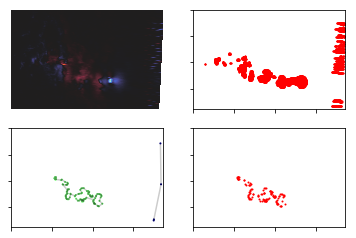

In [105]:
frame_num = 1110
image = data[frame_num]
imagename = 'image'+str(frame_num)
PIL_pipeline(image,penalty_C=1.0,threshold=97,show=True,imagename=imagename,eps=30,min_samples=5)